# 条件VAE

     VAE from "Auto-Encoding Variational Bayes" (2014, D.P. Kingma et. al.)
    
     Kernel-author: Jackson Kang @ Deep-learning Lab. (Handong Global University, S.Korea)
     
     Author-email:  mskang@handong.edu

     python and pytorch version: python=3.7, pytorch=1.3.1

目标：能生成指定数值的手写字体。

In [48]:
import torch
import torch.nn as nn   # nn = Neural Network，创建神经网络的工具

import numpy as np      # 处理张量的“始祖”级库，Torch横行后现在一般用在库之间数据交流部分。

from tqdm import tqdm   # 进度可视化
from torchvision.utils import save_image, make_grid # 可视化工具

In [49]:
# Model Hyperparameters

dataset_path = '~/datasets'

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")


batch_size = 100    # for循环里面一次处理batch_size个samples

x_dim  = 784        # 输入和输出图片维度，784=28*28
hidden_dim = 400    # 中间层维度, Encoder: x_dim -> hidden_dim -> latent_dim
latent_dim = 200    # VAE Encode输出和Decode输入的隐空间维度

lr = 1e-3           # Learning-rate 学习率

epochs = 30         # 训练轮数

###    Step 1. Load (or download) Dataset

In [50]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 0, 'pin_memory': True} 

# MNIST数据集：http://yann.lecun.com/exdb/mnist/ , 6万+1万
# CelebA数据集：https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html , 20万图片，1万标签
# ImageNet数据集: https://www.image-net.org/ , 1千400万
train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)       # 训练用样本，6w
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)      # 测试用样本，1w

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

### Step 2. Define our model: Variational AutoEncoder (VAE)

In [51]:
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""

# 编码器：把输入降维到Latent
# 从nn.Module派生可以让有Learnable Parameters的成员变量保存到checkpoint里面。
class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)    # FC=Fully Connected Layer，示例没有使用卷积。
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)  # 用了两层全连接层。
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)  # 激活函数

        # New:
        self.FC_embed = nn.Linear(10, hidden_dim) # 训练时需要嵌入(embed)数字编号，Encoder,Decoder的输入部分都嵌入
        
        self.training = True
        
    def forward(self, x, label): # New: 加了label参数，里面就是x对应图片里的数字
        # nn.Linear: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
        # ReLU: https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html
        # LeakyReLU: https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html
        # 激活函数没有可训练参数，所以两层可以共用 
        h_       = self.LeakyReLU(self.FC_input(x))     # y1=w1*x1 + b1 (忽略了LeakyReLU)

        # New:
        # 直接嵌入个0-9大小的Tensor有缺点，用ONE-HOT方法嵌入
        # 数字ONE-HOT后变成这样：
        # 0: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        # 1: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
        # 2: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
        # ...
        # 9: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
        embedding = nn.functional.one_hot(label, 10).float() # [N, 1](int) -> [N, 10](float)
        embedding = self.FC_embed(embedding) # [N, 10] -> [N, hidden_dim(400)], 用linear转换下维度，不然后面加法没法用
        h_ = h_ + embedding # 这里用加法做embed，也可以concat，加法好处是保证维度不变。为啥可以“加”？

        h_       = self.LeakyReLU(self.FC_input2(h_))   # y2=w2*y1 + b2
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var # 这就是输出的Latent，均值和方差

In [52]:
# 解码器：接受Latent，升维到输出维。
# 解码器把编码器“倒”过来执行了一遍。
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)

        # New:
        self.FC_embed = nn.Linear(10, hidden_dim) # 训练时需要嵌入(embed)数字编号，Encoder,Decoder的输入部分都嵌入

    def forward(self, x, label):
        h_     = self.LeakyReLU(self.FC_hidden(x))

        # New: copy encoder的代码
        embedding = nn.functional.one_hot(label, 10).float() # [N, 1](int) -> [N, 10](float)
        embedding = self.FC_embed(embedding) # [N, 10] -> [N, hidden_dim(400)]
        h_ = h_ + embedding

        h_     = self.LeakyReLU(self.FC_hidden2(h_))
        
        # nn.Sigmoid: https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html
        x_hat = torch.sigmoid(self.FC_output(h_)) # 输出需要一个[0, 1]的灰度值
        return x_hat
        

In [53]:
# 主模型
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
    
    # VAE里面V(ariational)的含义，重参数技巧。
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
    def forward(self, x, label): # New: 加了label参数
        # 1: 编码
        mean, log_var = self.Encoder(x, label)
        # 用重参数技巧解决梯度传递问题。
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        # 2: 解码
        x_hat            = self.Decoder(z, label) # Hat表示x头上顶个"帽子"那种符号，一般表示“估计值”，也就是AI预测出来的值。
        
        return x_hat, mean, log_var

In [54]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

### Step 3. Define Loss function (reprod. loss) and optimizer

In [55]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

# 损失函数
def loss_function(x, x_hat, mean, log_var):
    # VAE损失函数推导：https://medium.com/retina-ai-health-inc/variational-inference-derivation-of-the-variational-autoencoder-vae-loss-function-a-true-story-3543a3dc67ee
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=lr) # 优化器，Adam是SGD的进阶版。   

### Step 4. Train Variational AutoEncoder (VAE)

In [56]:
print("Start training VAE...")
model.train()   # 切换到训练模式

# 主训练循环
for epoch in range(epochs):
    overall_loss = 0
    # Old: for batch_idx, (x, _) in enumerate(train_loader):
    for batch_idx, (x, label) in enumerate(train_loader):
        x = x.view(batch_size, x_dim) # 每次训练batch_size个样本；把[N,1,W,H]“拉直”成[N,W*H]
        # x的shape和模型类型有关系：
        # [N,C]: 本Demo用，一般很少这么用。
        # [N,C,L]: Transformer类模型用，L是Token长度。Tensorflow: [N,L,C]
        # [N,C,H,W]: 图像处理类模型用
        x = x.to(DEVICE)        # 我们要用GPU训练
        label = label.to(DEVICE)

        optimizer.zero_grad()   # 清空旧的梯度

        x_hat, mean, log_var = model(x, label) # 运行主模型
        loss = loss_function(x, x_hat, mean, log_var) # 计算损失
        
        overall_loss += loss.item()     # 累积每个epoch的损失，后面用来求均值。
        
        loss.backward()     # 反向转播，产生各个Layer的梯度
        optimizer.step()    # 更新模型参数
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    
print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  155.58537331098705
	Epoch 2 complete! 	Average Loss:  121.41607723484454
	Epoch 3 complete! 	Average Loss:  112.01737219910788
	Epoch 4 complete! 	Average Loss:  108.32584952785894
	Epoch 5 complete! 	Average Loss:  105.72733478323246
	Epoch 6 complete! 	Average Loss:  103.9587694171275
	Epoch 7 complete! 	Average Loss:  102.85962701507721
	Epoch 8 complete! 	Average Loss:  102.0204079064065
	Epoch 9 complete! 	Average Loss:  101.22490886503547
	Epoch 10 complete! 	Average Loss:  100.6411103140651
	Epoch 11 complete! 	Average Loss:  100.20308313334725
	Epoch 12 complete! 	Average Loss:  99.80776945951585
	Epoch 13 complete! 	Average Loss:  99.41852239083369
	Epoch 14 complete! 	Average Loss:  99.1011341167571
	Epoch 15 complete! 	Average Loss:  98.80668265468489
	Epoch 16 complete! 	Average Loss:  98.55013414284224
	Epoch 17 complete! 	Average Loss:  98.31666265064169
	Epoch 18 complete! 	Average Loss:  98.13966602866758
	Epoch 1

### Step 5. Generate images from test dataset

In [63]:
import matplotlib.pyplot as plt # matplotlib是常用的可视化库

In [70]:
model.eval() # 切换到“评估”模式

with torch.no_grad(): # 禁止梯度下降相关功能
    for batch_idx, (x, label) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        label = label.to(DEVICE)
        
        x_hat, _, _ = model(x, label)


        break

  0%|          | 0/100 [00:00<?, ?it/s]


In [105]:
# 一个显示图片的工具函数
def show_image(x, input_label, idx):
    x = x.view(batch_size, 28, 28)      # 把“拉直”了的Tensor变回图片（方块图）

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())    # plot需要numpy格式的数据，不能传torch.Tensor

    print(f"Label: {input_label[idx].item()}")

Input Label: 7


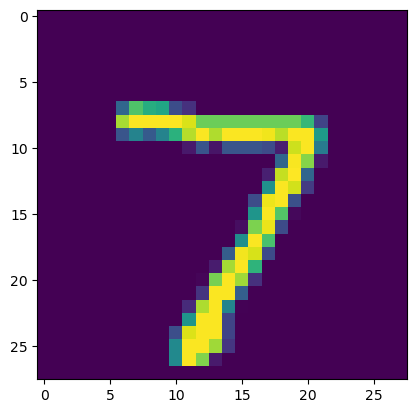

In [73]:
# 显示输入数据
show_image(x, label, idx=0)

Input Label: 0


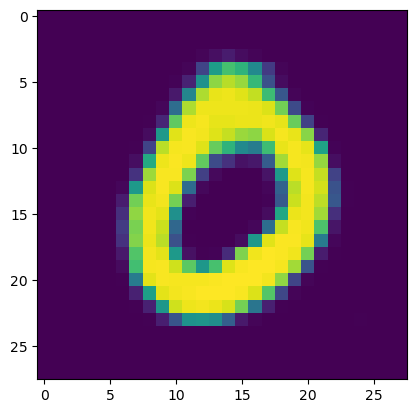

In [75]:
# 显示模型输出
show_image(x_hat, label, idx=3)

### Step 6. Generate image from noise vector

**Please note that this is not the correct generative process.**

* Even if we don't know exact p(z|x), we can generate images from noise, since the loss function of training VAE regulates the q(z|x) (simple and tractable posteriors) must close enough to N(0, I). If q(z|x) is close to N(0, I) "enough"(but not tightly close due to posterior collapse problem), N(0, I) may replace the encoder of VAE.

* To show this, I just tested with a noise vector sampled from N(0, I) similar with Generative Adversarial Network.

In [108]:
# 测测生成效果：直接从随机值产生一个图片
# 注意没有encoder了
def sample_image(no: int):    
    with torch.no_grad():
        label = torch.full((batch_size,), no, device=DEVICE)

        noise = torch.randn(batch_size, latent_dim).to(DEVICE)
        generated_images = decoder(noise, label)
    return generated_images, label

In [20]:
# save_image(generated_images.view(batch_size, 1, 28, 28), 'generated_sample.png')

Label: 5


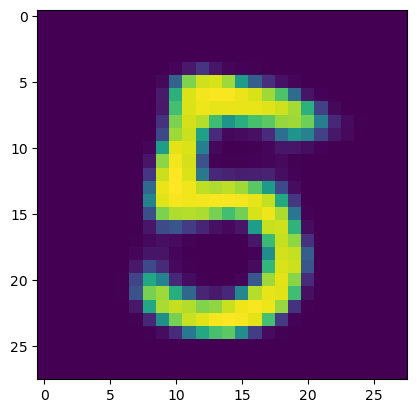

In [126]:
NO = 5
x_hat, label = sample_image(NO)
show_image(x_hat, label, idx=0)